#### Imports

In [ ]:
!pip install scikit-dimension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from numpy.linalg import eigvals
from skdim.id import CorrInt, MiND_ML, MLE, DANCo

#### Define measures of dimensionality

In [ ]:
def compute_linear_dim(data):
    """
    Compute linear dimensionality using participation ratio.
    """
    # Center and scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Compute covariance matrix and its eigenvalues
    cov = data_scaled.T @ data_scaled
    eigenvals = np.real(eigvals(cov))

    # Compute participation ratio
    num = np.sum(eigenvals) ** 2
    den = np.sum(eigenvals ** 2)
    pr = num / (den + 1e-17)  # avoid division by zero
    return pr

def compute_nonlinear_dim(data):
    """
    Compute non-linear dimensionality using multiple estimators.
    Returns the average dimension and individual estimator results.
    """
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    dims_mat = np.zeros(4)  # using four different estimators
    dims_mat[0] = CorrInt().fit(data_scaled).dimension_
    dims_mat[1] = MiND_ML().fit(data_scaled).dimension_
    dims_mat[2] = MLE().fit(data_scaled).dimension_
    dims_mat[3] = DANCo().fit(data_scaled).dimension_

    return np.mean(dims_mat), dims_mat


In [ ]:
# base_states = np.eye(5)
# states = np.random.choice(5, 1000)
# data = base_states[states]

# lin_dim = compute_linear_dim(data)
# nonlin_dim_avg, nonlin_dims = compute_nonlinear_dim(data)

#### Define functions to generate data

In [ ]:
def generate_structured_data(n_samples=1000, n_dims=50, structure_type='projected_one_hot'):
    """
    Generate data with different types of structure.

    Types:
    - 'projected_one_hot':
        One-hot encoding of 5 discrete states, projected via a sparse (30% nonzero) matrix.
    - 'smooth_direct_projection':
        3 latent variables; each dimension is a sum of sin/cos functions with random frequency/phase.
    - 'smooth_intermediate_projection':
        Uses 3 latent variables expanded via multiple sin/cos transformations and then projected.
    - 'localized_gaussian':
        A localized Gaussian bump. A single latent variable in [0,1] is mapped to each neuron
        with a preferred stimulus (center), producing a finite-width tuning curve.
    """
    if structure_type == 'projected_one_hot':
        # One-hot code for 5 states
        base_states = np.eye(5)
        states = np.random.choice(5, n_samples)
        data = base_states[states]

        # Sparse projection
        projection = np.random.randn(5, n_dims)
        sparsity_mask = np.random.binomial(1, 0.3, size=(5, n_dims))
        projection *= sparsity_mask

        data = data @ projection
        data += 0.01 * np.random.randn(*data.shape)  # small noise

    elif structure_type == 'smooth_direct_projection':
        # 3 latent variables
        latent = np.random.uniform(0, 2*np.pi, (n_samples, 3))
        data = np.zeros((n_samples, n_dims))
        for i in range(n_dims):
            phase = np.random.uniform(0, 2*np.pi)
            freq = np.random.uniform(0.5, 2)
            data[:, i] = (
                np.sin(freq * latent[:, 0] + phase) +
                np.cos(freq * latent[:, 1] + phase) +
                np.sin(freq * (latent[:, 0] + latent[:, 1]) + phase)
            )

    elif structure_type == 'smooth_intermediate_projection':
        # Same 3 latents, but with more elaborate expansions
        latent = np.random.uniform(0, 2*np.pi, (n_samples, 3))
        expansions_dim = 15
        expansions = np.zeros((n_samples, expansions_dim))

        for j in range(expansions_dim):
            alpha = np.random.uniform(-1.0, 1.0, size=3)
            freq = np.random.uniform(0.5, 2.5)
            phase = np.random.uniform(0, 2*np.pi)
            lin_combo = latent @ alpha  # shape: (n_samples,)
            if np.random.rand() < 0.5:
                expansions[:, j] = np.sin(freq * lin_combo + phase)
            else:
                expansions[:, j] = np.cos(freq * lin_combo + phase)

        # Project the 15D expansions into n_dims
        projection = np.random.randn(expansions_dim, n_dims)
        data = expansions @ projection

    elif structure_type == 'localized_gaussian':
        # One latent variable representing a stimulus parameter in [0, 1]
        latent = np.random.uniform(0, 1, (n_samples, 1))
        # Each neuron/dimension gets a random preferred stimulus (center)
        centers = np.random.uniform(0, 1, (1, n_dims))
        # Finite tuning width (sigma controls the bump's width)
        sigma = 0.1
        # Gaussian tuning curves for each neuron
        data = np.exp(-((latent - centers) ** 2) / (2 * sigma ** 2))
        # Add a small amount of noise
        data += 0.01 * np.random.randn(*data.shape)

    else:
        raise ValueError(f"Unknown structure type: {structure_type}")

    # Standardize features
    data = StandardScaler().fit_transform(data)
    return data

#### Generate data and compute results

In [ ]:
# np.random.seed(8)
n_samples = 1000
n_dims = 50

structure_types = ['projected_one_hot', 'localized_gaussian', 'smooth_direct_projection', 'smooth_intermediate_projection']

results = {}
for structure in structure_types:
    data = generate_structured_data(n_samples, n_dims, structure)
    lin_dim = compute_linear_dim(data)
    nonlin_dim_avg, nonlin_dims = compute_nonlinear_dim(data)
    results[structure] = {
        'linear_dim': lin_dim,
        'nonlinear_dim_avg': nonlin_dim_avg,
        'nonlinear_dims': nonlin_dims,
        'dimension_gain': lin_dim / nonlin_dim_avg
    }

#### Plot results

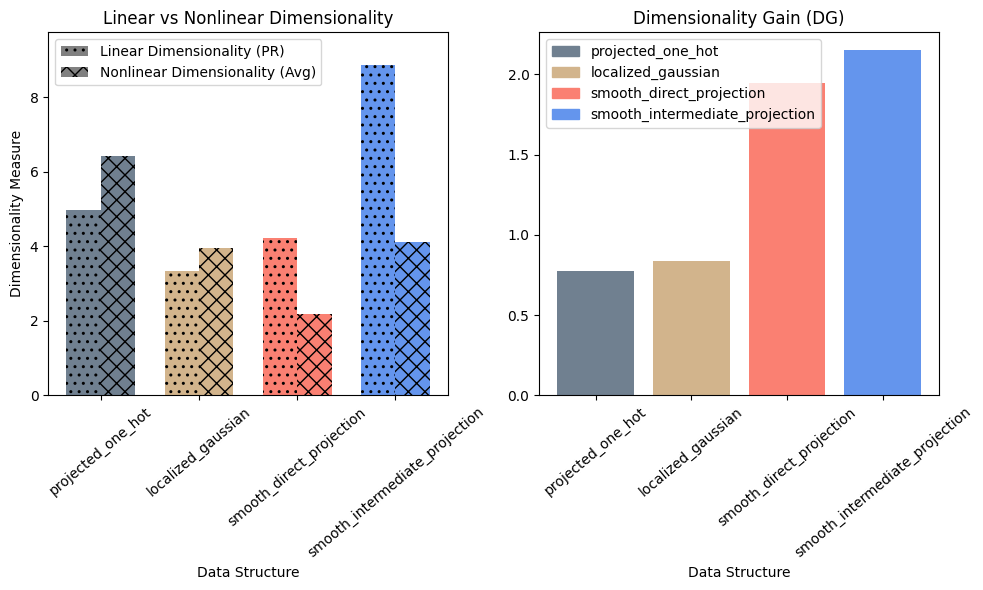

In [ ]:
colors = ['slategrey', 'tan', 'salmon', 'cornflowerblue']
n_groups = len(structure_types)
index = np.arange(n_groups)
bar_width = 0.35

# Get values for the grouped plot
linear_vals = [results[s]['linear_dim'] for s in structure_types]
nonlinear_vals = [results[s]['nonlinear_dim_avg'] for s in structure_types]
# Set a common y-axis limit (add a little margin)
y_max = max(max(linear_vals), max(nonlinear_vals)) * 1.1

plt.figure(figsize=(10, 6))

# --- Grouped Bar Plot for Linear and Nonlinear Dimensionality ---
plt.subplot(121)
for i, s in enumerate(structure_types):
    # Plot Linear bar (left side of group)
    plt.bar(index[i] - bar_width/2, results[s]['linear_dim'],
            width=bar_width, color=colors[i], hatch='..')
    # Plot Nonlinear bar (right side of group)
    plt.bar(index[i] + bar_width/2, results[s]['nonlinear_dim_avg'],
            width=bar_width, color=colors[i], hatch='xx')

plt.title('Linear vs Nonlinear Dimensionality')
plt.xlabel('Data Structure')
plt.ylabel('Dimensionality Measure')
plt.xticks(index, structure_types, rotation=40)
plt.ylim(0, y_max)

# Create custom legend handles for the hatch patterns (metrics)
linear_patch = mpatches.Patch(facecolor='grey', hatch='..', label='Linear Dimensionality (PR)')
nonlinear_patch = mpatches.Patch(facecolor='grey', hatch='xx', label='Nonlinear Dimensionality (Avg)')
plt.legend(handles=[linear_patch, nonlinear_patch])

# --- Bar Plot for Dimensionality Gain ---
plt.subplot(122)
for i, s in enumerate(structure_types):
    plt.bar(i, results[s]['dimension_gain'], color=colors[i])
plt.title('Dimensionality Gain (DG)')
plt.xlabel('Data Structure')
plt.xticks(np.arange(n_groups), structure_types, rotation=40)

# Create legend handles for the structure types based on color
structure_patches = [mpatches.Patch(color=colors[i], label=structure_types[i])
                     for i in range(n_groups)]
plt.legend(handles=structure_patches)

plt.tight_layout()
plt.show()

In [ ]:
# Print details
print("\nDetailed Results:")
for structure in structure_types:
    print(f"\nStructure: {structure}")
    print(f"Linear Dim (PR): {results[structure]['linear_dim']:.2f}")
    print(f"Nonlinear Dim (Avg): {results[structure]['nonlinear_dim_avg']:.2f}")
    print("Individual Estimators:")
    est_names = ["CorrInt", "MiND_ML", "MLE", "DANCo"]
    for name, val in zip(est_names, results[structure]['nonlinear_dims']):
        print(f"  {name}: {val:.2f}")
    print(f"DG = {results[structure]['dimension_gain']:.2f}")


Detailed Results:

Structure: projected_one_hot
Linear Dim (PR): 4.96
Nonlinear Dim (Avg): 6.43
Individual Estimators:
  CorrInt: 5.10
  MiND_ML: 6.50
  MLE: 6.07
  DANCo: 8.03
DG = 0.77

Structure: localized_gaussian
Linear Dim (PR): 3.32
Nonlinear Dim (Avg): 3.96
Individual Estimators:
  CorrInt: 1.61
  MiND_ML: 3.91
  MLE: 2.33
  DANCo: 8.00
DG = 0.84

Structure: smooth_direct_projection
Linear Dim (PR): 4.23
Nonlinear Dim (Avg): 2.17
Individual Estimators:
  CorrInt: 2.10
  MiND_ML: 2.11
  MLE: 2.12
  DANCo: 2.36
DG = 1.95

Structure: smooth_intermediate_projection
Linear Dim (PR): 8.85
Nonlinear Dim (Avg): 4.11
Individual Estimators:
  CorrInt: 4.51
  MiND_ML: 3.57
  MLE: 3.87
  DANCo: 4.49
DG = 2.15


#### Plot examples of the data in 2D/3D

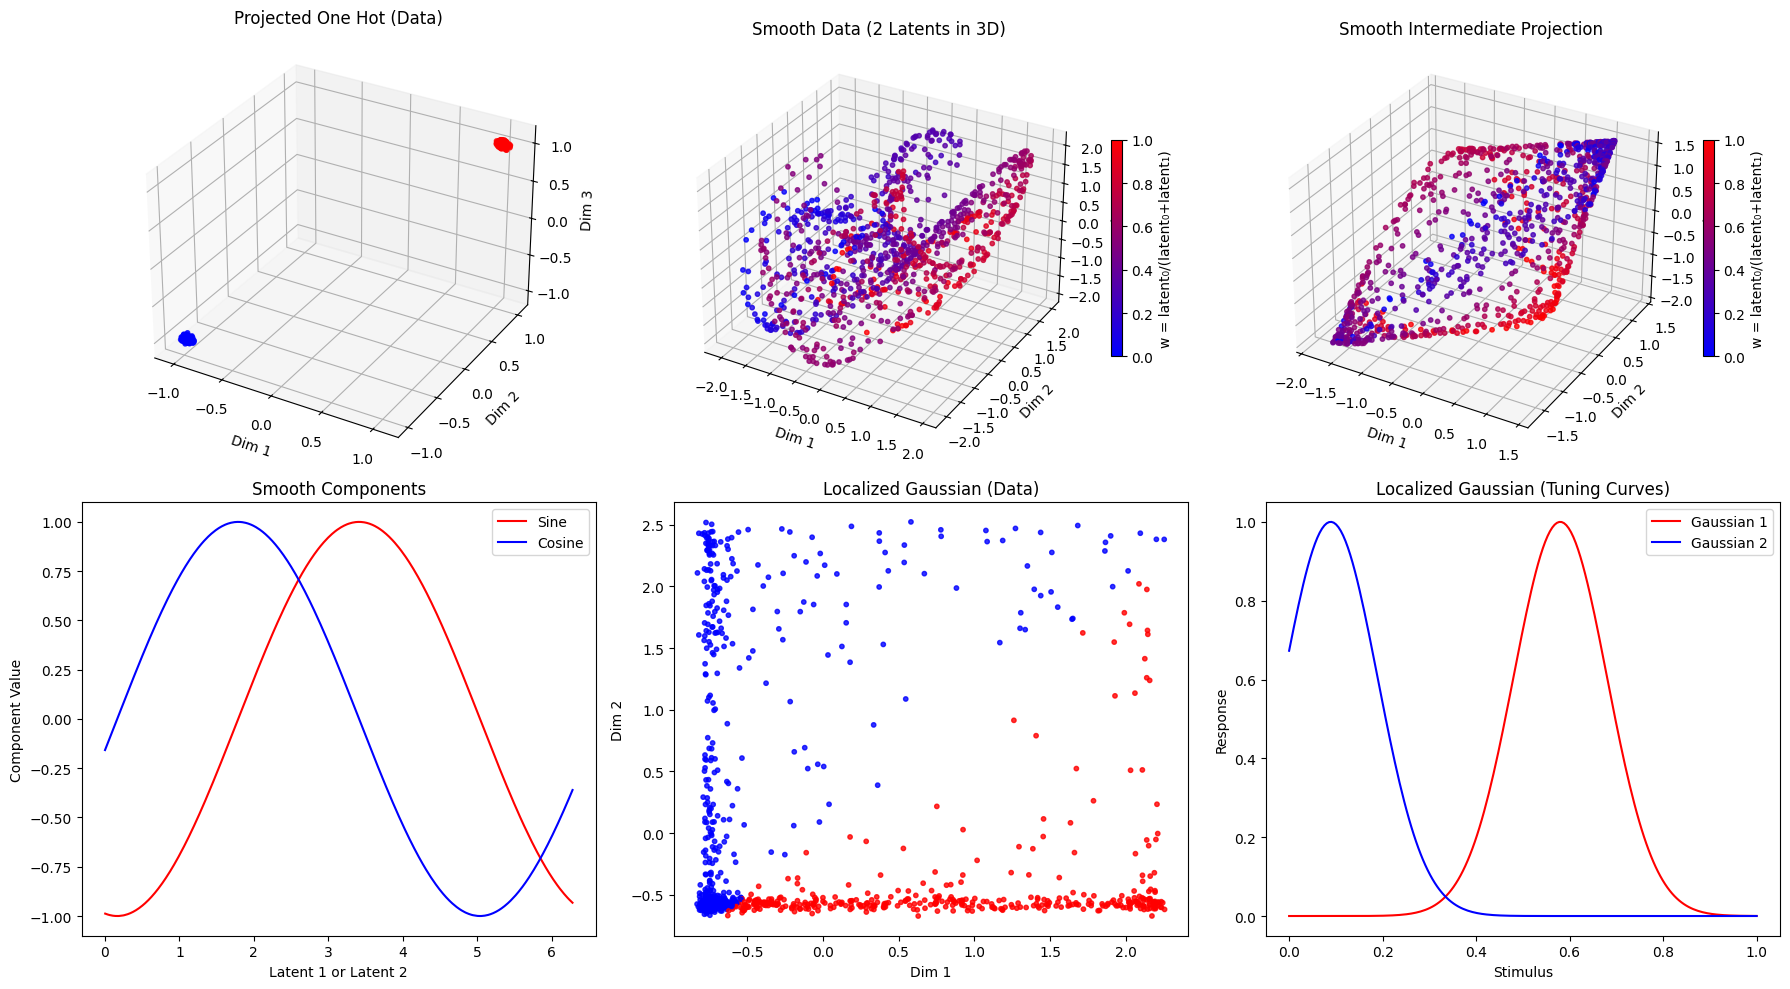

In [ ]:
# 1) Define a custom red–blue colormap (0 → blue, 1 → red)
red_blue = mcolors.LinearSegmentedColormap.from_list("red_blue", ["blue", "red"])

def generate_structured_data_plotter(n_samples=1000, n_dims=3, structure_type='projected_one_hot'):
    """
    Generate data with different types of structure, renamed:
      - 'projected_one_hot': same as before
      - 'smooth_direct_projection': previously 'smooth_simple'
      - 'smooth_intermediate_projection': previously 'smooth_complex'
      - 'localized_gaussian': same as before
    """
    if structure_type == 'projected_one_hot':
        # One-hot code for 2 states
        base_states = np.eye(2)
        states = np.random.choice(2, n_samples)
        onehot = base_states[states]

        # Sparse projection
        projection = np.random.randn(2, n_dims)
        sparsity_mask = np.random.binomial(1, 0.3, size=(2, n_dims))
        projection *= sparsity_mask

        data = onehot @ projection
        data += 0.01 * np.random.randn(*data.shape)

        latent = states
        extra = {'onehot': onehot}
        data = StandardScaler().fit_transform(data)
        return data, latent, extra

    elif structure_type == 'smooth_direct_projection':  # previously 'smooth_simple'
        latent = np.random.uniform(0, 2*np.pi, (n_samples, 2))
        data = np.zeros((n_samples, n_dims))

        # For dimension 0, store sine/cosine in extra
        phase0 = np.random.uniform(0, 2*np.pi)
        freq0  = np.random.uniform(0.5, 2)
        comp_sine = np.sin(freq0 * latent[:, 0] + phase0)
        comp_cos  = np.cos(freq0 * latent[:, 1] + phase0)
        for i in range(n_dims):
            if i == 0:
                data[:, i] = comp_sine + comp_cos
            else:
                phase = np.random.uniform(0, 2*np.pi)
                freq  = np.random.uniform(0.5, 2)
                data[:, i] = (
                    np.sin(freq * latent[:, 0] + phase)
                    + np.cos(freq * latent[:, 1] + phase)
                )
        extra = {'comp_sine': comp_sine, 'comp_cos': comp_cos}
        data = StandardScaler().fit_transform(data)
        return data, latent, extra

    elif structure_type == 'smooth_intermediate_projection':  # previously 'smooth_complex'
        latent = np.random.uniform(0, 2*np.pi, (n_samples, 2))
        expansions_dim = 3
        expansions = np.zeros((n_samples, expansions_dim))

        expansions_info = []
        for j in range(expansions_dim):
            alpha = np.random.uniform(-1.0, 1.0, size=2)
            freq  = np.random.uniform(0.5, 2.5)
            phase = np.random.uniform(0, 2*np.pi)

            lin_combo = latent @ alpha
            if np.random.rand() < 0.5:
                expansions[:, j] = np.sin(freq * lin_combo + phase)
            else:
                expansions[:, j] = np.cos(freq * lin_combo + phase)

            expansions_info.append({
                'alpha': alpha,
                'freq': freq,
                'phase': phase
            })

        projection = np.random.randn(expansions_dim, n_dims)
        data = expansions @ projection

        extra = {
            'expansions': expansions,
            'projection': projection,
            'expansions_info': expansions_info
        }
        data = StandardScaler().fit_transform(data)
        return data, latent, extra

    elif structure_type == 'localized_gaussian':
        n_dims = 2
        latent = np.random.uniform(0, 1, (n_samples, 2))
        centers = np.random.uniform(0, 1, (1, n_dims))
        sigma = 0.1
        data = np.exp(-((latent - centers) ** 2) / (2 * sigma ** 2))
        data += 0.01 * np.random.randn(*data.shape)
        extra = {}
        data = StandardScaler().fit_transform(data)
        return data, latent, centers, extra

    else:
        raise ValueError(f"Unknown structure type: {structure_type}")

def plot_all_stimuli(n_samples=1000, n_dims=3, random_state=42):
    """
    Produce a 2-row × 3-column figure:

     Row 1, Col 1: Projected One Hot data (3D)
     Row 1, Col 2: Smooth Direct Projection data (3D)
     Row 1, Col 3: Smooth Intermediate Projection data (3D)

     Row 2, Col 1: Localized Gaussian data (2D)
     Row 2, Col 2: Smooth Direct Projection components (1D curves)
     Row 2, Col 3: Localized Gaussian tuning curves
    """
    np.random.seed(random_state)

    fig = plt.figure(figsize=(18, 10))

    # --- 1) Projected One Hot (3D) ---
    data_ph, latent_ph, extra_ph = generate_structured_data_plotter(
        n_samples=n_samples, n_dims=n_dims, structure_type='projected_one_hot'
    )
    ax_11 = fig.add_subplot(2,3,1, projection='3d')
    # Discrete red/blue
    colors_ph = np.array(['red' if x==0 else 'blue' for x in latent_ph])
    ax_11.scatter(data_ph[:,0], data_ph[:,1], data_ph[:,2], c=colors_ph, s=10, alpha=0.8)
    ax_11.set_title("Projected One Hot (Data)")
    ax_11.set_xlabel("Dim 1")
    ax_11.set_ylabel("Dim 2")
    ax_11.set_zlabel("Dim 3")

    # --- 2) Smooth Direct Projection (3D) ---
    data_snp, latent_snp, extra_snp = generate_structured_data_plotter(
        n_samples=n_samples, n_dims=n_dims, structure_type='smooth_direct_projection'
    )
    ax_12 = fig.add_subplot(2,3,2, projection='3d')
    w_snp = latent_snp[:,0] / (latent_snp[:,0] + latent_snp[:,1])
    colors_snp = red_blue(w_snp)
    ax_12.scatter(data_snp[:,0], data_snp[:,1], data_snp[:,2], c=colors_snp, s=10, alpha=0.8)
    ax_12.set_title("Smooth Data (2 Latents in 3D)")
    ax_12.set_xlabel("Dim 1")
    ax_12.set_ylabel("Dim 2")
    ax_12.set_zlabel("Dim 3")
    cb_snp = plt.colorbar(
        ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=1), cmap=red_blue),
        ax=ax_12, shrink=0.5
    )
    cb_snp.set_label("w = latent₀/(latent₀+latent₁)")

    # --- 3) Smooth Intermediate Projection (3D) ---
    data_sip, latent_sip, extra_sip = generate_structured_data_plotter(
        n_samples=n_samples, n_dims=n_dims, structure_type='smooth_intermediate_projection'
    )
    ax_13 = fig.add_subplot(2,3,3, projection='3d')
    w_sip = latent_sip[:,0] / (latent_sip[:,0] + latent_sip[:,1])
    colors_sip = red_blue(w_sip)
    ax_13.scatter(data_sip[:,0], data_sip[:,1], data_sip[:,2], c=colors_sip, s=10, alpha=0.8)
    ax_13.set_title("Smooth Intermediate Projection")
    ax_13.set_xlabel("Dim 1")
    ax_13.set_ylabel("Dim 2")
    ax_13.set_zlabel("Dim 3")
    cb_sip = plt.colorbar(
        ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=1), cmap=red_blue),
        ax=ax_13, shrink=0.5
    )
    cb_sip.set_label("w = latent₀/(latent₀+latent₁)")

    # --- 4) Smooth No Projection (Components) ---
    ax_21 = fig.add_subplot(2,3,4)
    comp_sine = extra_snp['comp_sine']
    comp_cos  = extra_snp['comp_cos']
    idx_sine = np.argsort(latent_snp[:,0])
    idx_cos  = np.argsort(latent_snp[:,1])
    ax_21.plot(latent_snp[idx_sine,0], comp_sine[idx_sine], label="Sine", color='red')
    ax_21.plot(latent_snp[idx_cos,1],   comp_cos[idx_cos],  label="Cosine", color='blue')
    ax_21.set_xlabel("Latent 1 or Latent 2")
    ax_21.set_ylabel("Component Value")
    ax_21.set_title("Smooth Components")
    ax_21.legend()

    # --- 5) Localized Gaussian (2D) ---
    data_lg, latent_lg, centers_lg, extra_lg = generate_structured_data_plotter(
        n_samples=n_samples, n_dims=n_dims, structure_type='localized_gaussian'
    )
    ax_22 = fig.add_subplot(2,3,5)
    colors_lg = np.array(['red' if d0>d1 else 'blue' for d0,d1 in zip(data_lg[:,0], data_lg[:,1])])
    ax_22.scatter(data_lg[:,0], data_lg[:,1], c=colors_lg, s=10, alpha=0.8)
    ax_22.set_title("Localized Gaussian (Data)")
    ax_22.set_xlabel("Dim 1")
    ax_22.set_ylabel("Dim 2")

    # --- 6) Localized Gaussian (Tuning Curves) ---
    ax_23 = fig.add_subplot(2,3,6)
    sigma = 0.1
    x_vals = np.linspace(0, 1, 200)
    tuning_red  = np.exp(-((x_vals - centers_lg[0,0])**2)/(2*sigma**2))
    tuning_blue = np.exp(-((x_vals - centers_lg[0,1])**2)/(2*sigma**2))
    ax_23.plot(x_vals, tuning_red,  color='red',  label="Gaussian 1")
    ax_23.plot(x_vals, tuning_blue, color='blue', label="Gaussian 2")
    ax_23.set_xlabel("Stimulus")
    ax_23.set_ylabel("Response")
    ax_23.set_title("Localized Gaussian (Tuning Curves)")
    ax_23.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_all_stimuli()